In [1]:
from PIL import Image, ImageDraw, ImageFilter
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import keras
from keras import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Convolution2D,AveragePooling2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from keras import optimizers
from tqdm import tqdm
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (8,6)
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
model_red=keras.models.load_model('../trained_models/red_10k.h5')
model_blue=keras.models.load_model('../trained_models/blue_10k.h5')
model_white=keras.models.load_model('../trained_models/white_10k.h5')
model_yellow=keras.models.load_model('../trained_models/yellow_10k.h5')

In [3]:
def plot(X,Y_arr,linewidth=2):
    plt.imshow(X.astype(np.float32))
    p=2*300/100
    c_arr=['b','r','w','y']
    for i in range(len(Y_arr)):
        Y=Y_arr[i]
        c=c_arr[i%4]
        plt.scatter([Y[1]+p,Y[0]-p,Y[1]+p,Y[0]-p],\
                [Y[2]-p,Y[2]-p,Y[3]+p,Y[3]+p],c=c)
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((Y[0]-p,Y[2]-p),Y[1]-Y[0]+2*p,Y[3]-Y[2]+2*p,linewidth=linewidth,edgecolor=c,facecolor='none'))
    return plt

### 2 signs on the same image

In [4]:
im=np.load('../data/blue/image_15.npy')/255
red_pred=model_red.predict(np.array([im]))[0]*300
blue_pred=model_blue.predict(np.array([im]))[0]*300
white_pred=model_white.predict(np.array([im]))[0]*300
yellow_pred=model_yellow.predict(np.array([im]))[0]*300

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

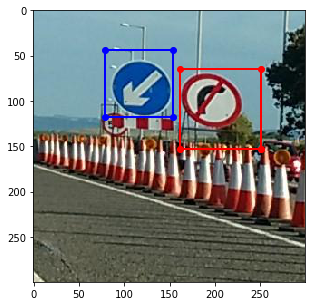

In [5]:
plt.figure(figsize=(5,5))
plot(im,[blue_pred,red_pred])

### Sliding window

In [6]:
def plot(X,Y_arr,color_arr,lw=2):
    plt.imshow(X.astype(np.float32))
    p=2*300/100
    c_arr=['b','r','w','y']
    for i in range(len(Y_arr)):
        Y=Y_arr[i]
        c=color_arr[i]
        #plt.scatter([Y[1]+p,Y[0]-p,Y[1]+p,Y[0]-p],[Y[2]-p,Y[2]-p,Y[3]+p,Y[3]+p],c=c)
        ax = plt.gca()
        ax.add_patch(patches.Rectangle((Y[0]-p,Y[2]-p),Y[1]-Y[0]+2*p,Y[3]-Y[2]+2*p,linewidth=lw,edgecolor=c,facecolor='none'))
    return plt

In [8]:
def proposals(im):
    im=im/255
    r=model_red.predict(np.array([im]))[0]*300
    b=model_blue.predict(np.array([im]))[0]*300
    w=model_white.predict(np.array([im]))[0]*300
    y=model_yellow.predict(np.array([im]))[0]*300
    return [(r,'r'),(w,'w'),(y,'y'),(b,'b')]

In [9]:
classifier=keras.models.load_model('../trained_models/binaryclassifier.h5')

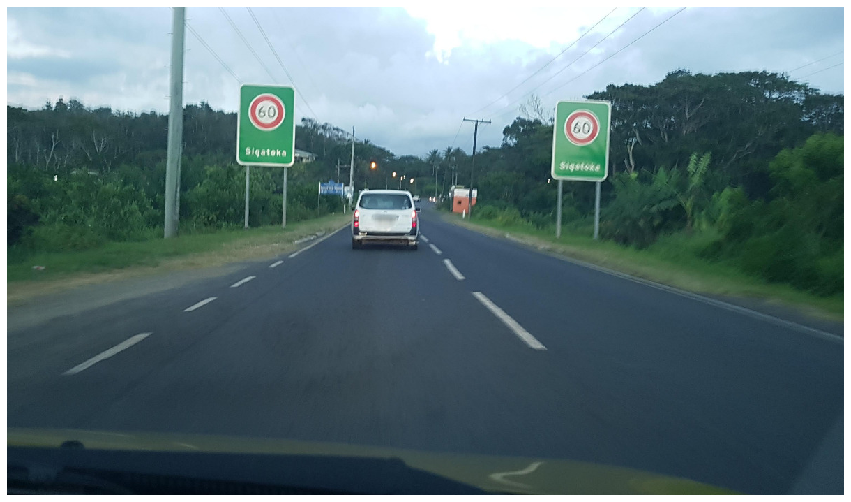

In [63]:
plt.figure(figsize=(15,15))
big_im = Image.open("../data/test/big8.jpg").crop((200,100,1400,800))
y_size,x_size,_=np.array(big_im).shape
plt.imshow(np.array(big_im))
plt.axis('off')
plt.savefig('orig.png',bbox_inches='tight',pad_inches=0,transparent=True)

In [64]:
bigprops=[]
bigpreds=[]
for length in min(y_size,x_size)*np.array([.2,.3]):
    for x_top_left in range(0,x_size,int(0.3*length)):
        for y_top_left in range(0,y_size,int(0.3*length)):
            piece=np.array(big_im.crop((x_top_left, y_top_left, x_top_left+length, y_top_left+length)).resize((300,300)))
            props=proposals(piece)
            for colored_proposal in props:
                p=colored_proposal[0]
                c=colored_proposal[1]
                box=[]
                for i in range(4):
                    if i==0 or i==1:
                        box+=[p[i]*length/300+x_top_left]
                    else:
                        box+=[p[i]*length/300+y_top_left]
                if box[1]>x_size or box[3]>y_size:
                    pass
                else:
                    bigprops+=[(box,c)]     
                    window=np.array(big_im)[int(box[2]):int(box[3]),int(box[0]):int(box[1])]
                    try:
                        window0=np.array(Image.fromarray(window).resize((32,32)))
                        bigpreds+=[(box,c,classifier.predict(np.array([window0/255]))[0][0])]   
                    except:
                        print(window.shape)
                    #classifier_prediction=classifier.predict(np.array([window0]))
                    #if classifier.predict(np.array([window0/255]))>=1:
                            
                    

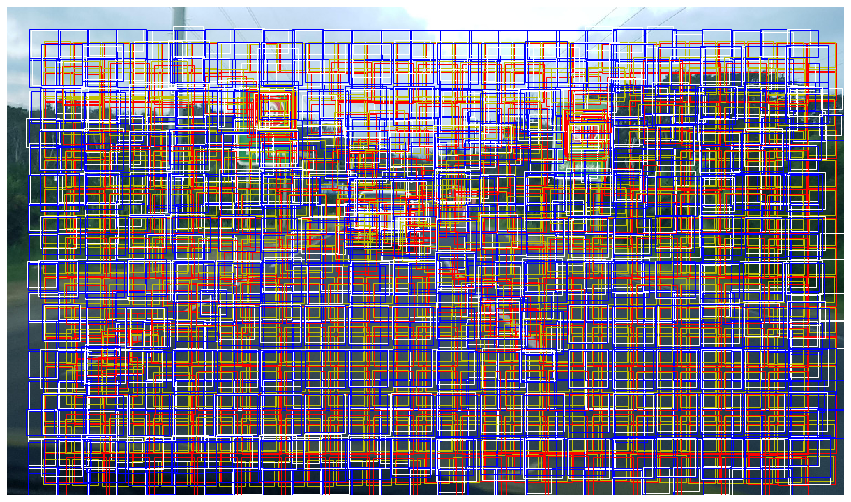

In [67]:
plt.figure(figsize=(15,15))
plot(np.array(big_im)/255,[p[0] for p in bigprops], [p[1] for p in bigprops],lw=1)
plt.axis('off')
plt.savefig('proposals.png',bbox_inches='tight',pad_inches=0,transparent=True)

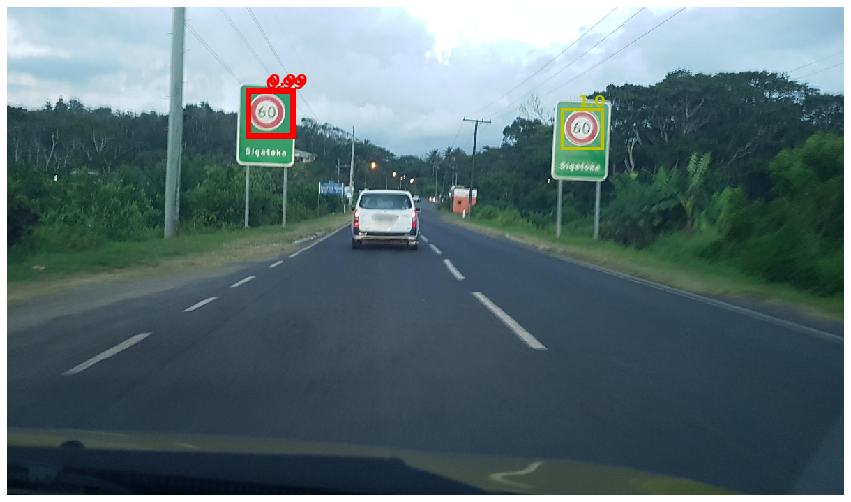

In [71]:
plt.figure(figsize=(15,15))
plotpred=[]
for i in bigpreds:
    if i[2]>.9998:
        plotpred+=[i]
plot(np.array(big_im)/255,[p[0] for p in plotpred], [p[1] for p in plotpred],lw=3)
for i in plotpred:
    if i[1] in ['b','w']:
        plt.text(int(i[0][0])-5,int(i[0][2])-10,str(i[2])[:4],fontdict={
        'color':  i[1],'weight': 'normal','fontweight':'bold','size': 16,})
    else:
        plt.text(int(i[0][1])-30,int(i[0][2])-10,str(i[2])[:4],fontdict={
        'color':  i[1],'weight': 'normal','fontweight':'bold','size': 16,})
plt.axis('off')
plt.savefig('slding_window.png',bbox_inches='tight',pad_inches=0,transparent=True)